In [6]:

import pandas as pd
import requests
from bs4 import BeautifulSoup

# Read the CSV file with route IDs
df = pd.read_csv("lapin_reitit.csv")

# Create an empty dictionary to store extracted data
extracted_data_dict = {}


# Create an empty DataFrame to store extracted data
extracted_data = pd.DataFrame(columns=['Tyyppi', 'Pituus', 'Nousua', 'Lisätty'])



# Iterate through each route ID
for route_id in df['ID']:
    # Construct the URL
    url = f"https://jalki.fi/routes/{route_id}"
    
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find the section with class "info content"
        info_section = soup.find('section', class_='info content')
        
        # Find all dt elements within the info section
        dt_elements = info_section.find_all('dt')
        
        # Find all dd elements within the info section
        dd_elements = info_section.find_all('dd')
        
        # Initialize a dictionary to store extracted data for this route
        route_data = {}
        
        # Iterate through each dt element and check its text to extract the desired information
        for dt, dd in zip(dt_elements, dd_elements):
            route_data[dt.text.strip()] = dd.text.strip()
        
            # Add the extracted data to the dictionary with route_id as the key
        extracted_data_dict[route_id] = route_data
    else:
        print(f"Failed to retrieve data for route with ID {route_id}")

# Convert the dictionary to a DataFrame
extracted_data_df = pd.DataFrame.from_dict(extracted_data_dict, orient='index')

# Write the extracted data to a CSV file
extracted_data_df.to_csv("extracted_data.csv")

print("Extraction complete. Data saved to extracted_data.csv")
print("Extraction complete. Data saved to extracted_data.csv")

Extraction complete. Data saved to extracted_data.csv
Extraction complete. Data saved to extracted_data.csv


In [11]:
df.set_index('ID', inplace=True)

df.head()

,Nimi,Katseluita,Latauksia
ID,,,
292,Rollo MTB (Rovaniemi),4423,1743
265,Kemi-Tervola,2261,1117
382,Ylläs-Levi maastopyöräreitti,12356,2432
628,Pellon Välikylästä Salmilompoloon ja takaisin,1798,841
436,Njuohgarggun reitti,2408,1065


In [13]:
merged_routes = pd.merge(df, extracted_data_df, left_index=True, right_index=True)

len(merged_routes)

277

In [33]:
import geopandas as gpd
import requests
import gpxpy 
from shapely.geometry import LineString
from io import BytesIO

# Function to download GPX file from a URL
def download_gpx(route_id):
    url = f"https://jalki.fi/routes/{route_id}.gpx"  # URL format for downloading GPX files
    response = requests.get(url)
    if response.status_code == 200:
        return response.content
    else:
        print(f"Failed to download GPX for route {route_id}")
        return None

# Iterate over the IDs and download GPX routes
for route_id in merged_routes.index:
    gpx_data = download_gpx(route_id)
    if gpx_data:
        # Parse GPX data
        gpx = gpxpy.parse(BytesIO(gpx_data))
        # Extract track points
        track_points = []
        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    track_points.append((point.longitude, point.latitude))
        # Convert track points to LineString geometry
        linestring = LineString(track_points)
        # Set the LineString geometry to the merged_data DataFrame
        merged_routes.at[route_id, 'geometry'] = linestring

        print(f'Processing route {route_id}')

# Save the merged DataFrame with geometry to a GeoJSON file
merged_gdf = gpd.GeoDataFrame(merged_routes, geometry='geometry')
# merged_gdf.to_file("merged_data.geojson", driver='GeoJSON')

print("GPX routes downloaded and added to merged_data. Saved to merged_data.geojson")



Processing route 292
Processing route 265
Processing route 382
Processing route 628
Processing route 436
Processing route 437
Processing route 438
Processing route 439
Processing route 440
Processing route 509
Processing route 640
Processing route 641
Processing route 643
Processing route 644
Processing route 645
Processing route 647
Processing route 648
Processing route 651
Processing route 666
Processing route 682
Processing route 684
Processing route 685
Processing route 686
Processing route 578
Processing route 579
Processing route 580
Processing route 581
Processing route 582
Processing route 583
Processing route 586
Processing route 594
Processing route 603
Processing route 705
Processing route 708
Processing route 709
Processing route 730
Processing route 731
Processing route 609
Processing route 1592
Processing route 1606
Processing route 1606
Processing route 777
Processing route 784
Processing route 785
Processing route 795
Processing route 895
Processing route 996
Processing

In [34]:
merged_gdf.crs = 'EPSG:4326'

In [35]:
merged_gdf.to_file("merged_data.gpkg", driver='GPKG')

<Axes: >

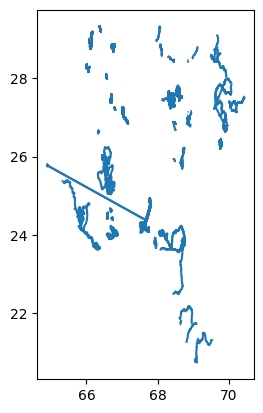

In [32]:
merged_gdf.plot()